In [28]:
import io
import os
import math
import copy
import pickle
import zipfile
import random
import pandas as pd
import numpy as np
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import matplotlib.pyplot as plt
from datetime import datetime
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import time
import copy
import syft as sy
from syft.frameworks.torch.fl import utils
from syft.workers.websocket_client import WebsocketClientWorker

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

In [3]:
data_dir = '../data/'
rating_file = data_dir + 'ratings.dat' 
user_file = data_dir + 'users.dat'
movie_file = data_dir + 'movies.dat'

In [4]:
df_rating = pd.read_csv(rating_file, sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])
df_user = pd.read_csv(user_file, sep='::', header=None, names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
df_movie = pd.read_csv(movie_file, sep='::', header=None, names=['movie_id', 'title', 'genre'])

In [5]:
age_group_dict = {
    1:  "Under 18",
    18:  "18-24",
    25:  "25-34",
    35:  "35-44",
    45:  "45-49",
    50:  "50-55",
    56:  "56+"
}

In [6]:
occupation_dict = {
    0:  "other or not specified",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10:  "K-12 student",
    11:  "lawyer",
    12:  "programmer",
    13:  "retired",
    14:  "sales/marketing",
    15:  "scientist",
    16:  "self-employed",
    17:  "technician/engineer",
    18:  "tradesman/craftsman",
    19:  "unemployed",
    20:  "writer"
}

In [7]:
df_temp = df_rating.merge(df_movie, left_on='movie_id', right_on='movie_id', how='left')
df = df_temp.merge(df_user, left_on='user_id', right_on='user_id', how='left')
df.head()

,user_id,movie_id,rating,timestamp,title,genre,gender,age,occupation,zipcode
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


In [8]:
def tabular_preview(ratings, n=15):
    
    user_groups = ratings.groupby('user_id')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('movie_id')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='user_id').
        join(top_movies, rsuffix='_r', how='inner', on='movie_id'))

    return pd.crosstab(top.user_id, top.movie_id, top.rating, aggfunc=np.sum)

In [9]:
tabular_preview(df)

movie_id,110,260,480,589,593,608,1196,1198,1210,1270,1580,2028,2571,2762,2858
user_id,,,,,,,,,,,,,,,
889,4.0,4.0,3.0,5.0,5.0,4.0,4.0,NaN,3.0,4.0,3.0,3.0,5.0,NaN,2.0
1015,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0
1150,2.0,5.0,NaN,2.0,3.0,5.0,4.0,2.0,3.0,2.0,2.0,2.0,1.0,2.0,4.0
1181,3.0,4.0,2.0,5.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,3.0
1449,3.0,3.0,2.0,2.0,5.0,5.0,3.0,4.0,2.0,2.0,4.0,3.0,4.0,4.0,4.0
1680,1.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,3.0,4.0,5.0,3.0,5.0,5.0
1941,5.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,1.0
1980,4.0,4.0,4.0,4.0,5.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0
2063,5.0,4.0,4.0,2.0,5.0,2.0,4.0,4.0,4.0,4.0,3.0,2.0,5.0,4.0,5.0


In [10]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('user_id')['rating'].count()
    
    unique_users = ratings.user_id.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.user_id.map(user_to_index)
    
    unique_movies = ratings.movie_id.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movie_id.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

In [11]:
(n, m), (X, y), _ = create_dataset(df)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 6040 users, 3706 movies
Dataset shape: (1000209, 2)
Target shape: (1000209,)


In [12]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [13]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [14]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[3808, 2234],
        [1388,  143],
        [4509,  849],
        [1016, 2393]])
tensor([[4.],
        [4.],
        [2.],
        [3.]])


In [15]:
class EmbeddingNet(nn.Module):
    '''
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    '''
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [16]:
EmbeddingNet(n, m, n_factors=150, hidden=100, dropouts=0.5)

EmbeddingNet(
  (u): Embedding(6040, 150)
  (m): Embedding(3706, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [17]:
EmbeddingNet(n, m, n_factors=150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])

EmbeddingNet(
  (u): Embedding(6040, 150)
  (m): Embedding(3706, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

In [18]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [19]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [20]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [21]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [23]:
minmax = float(df.rating.min()), float(df.rating.max())
minmax

(1.0, 5.0)

In [24]:
net = EmbeddingNet(
    n_users=n, n_movies=m, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [25]:
lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

cuda:0


In [26]:
class Parser:
    def __init__(self):
        self.epochs = 100
        self.lr = 0.001
        self.test_batch_size = 8
        self.batch_size = 8
        self.log_interval = 10
        self.seed = 1
    
args = Parser()
torch.manual_seed(args.seed)

In [43]:
hook = sy.TorchHook(torch)
bob_worker = sy.VirtualWorker(hook, id="bob")
alice_worker = sy.VirtualWorker(hook, id="alice")
# kwargs_websocket = {"host": "localhost", "hook": hook}
# alice = WebsocketClientWorker(id='alice', port=8779, **kwargs_websocket)
# bob = WebsocketClientWorker(id='bob', port=8778, **kwargs_websocket)
compute_nodes = [bob_worker, alice_worker]

In [44]:
train_loader = DataLoader([X_train, y_train], batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader([X_valid, y_valid], batch_size=args.test_batch_size, shuffle=True)

In [59]:
remote_dataset = (list(), list())
train_distributed_dataset = []

for batch_idx in range(len(X_train)):
    data = torch.tensor([X_train.iloc[0][0], X_train.iloc[0][1]])
    target = torch.tensor(y_train.iloc[0])
    data = data.send(compute_nodes[batch_idx % len(compute_nodes)])
    target = target.send(compute_nodes[batch_idx % len(compute_nodes)])
    remote_dataset[batch_idx % len(compute_nodes)].append((data, target))
    trainData.append(torch.tensor(data, target))

AttributeError: module 'msgpack' has no attribute 'dumps'

In [58]:
y_train.iloc[0]

IndexError: invalid index to scalar variable.

In [26]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        if phase == 'train':
            training = True
        else:
            training = False

        running_loss = 0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()

            #print(x_batch[:,0])
          
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/100] train: 0.8866 - val: 0.8221
loss improvement on epoch: 2
[002/100] train: 0.7963 - val: 0.8066
loss improvement on epoch: 3
[003/100] train: 0.7998 - val: 0.7984
loss improvement on epoch: 4
[004/100] train: 0.7582 - val: 0.7860
loss improvement on epoch: 5
[005/100] train: 0.7663 - val: 0.7852
loss improvement on epoch: 6
[006/100] train: 0.7287 - val: 0.7833
loss improvement on epoch: 7
[007/100] train: 0.7414 - val: 0.7829
[008/100] train: 0.6943 - val: 0.7888
[009/100] train: 0.7071 - val: 0.7854
[010/100] train: 0.6498 - val: 0.7985
[011/100] train: 0.6659 - val: 0.7933
[012/100] train: 0.6101 - val: 0.8085
[013/100] train: 0.6311 - val: 0.7984
[014/100] train: 0.5787 - val: 0.8139
[015/100] train: 0.6025 - val: 0.8100
[016/100] train: 0.5540 - val: 0.8249
[017/100] train: 0.5798 - val: 0.8197
early stopping after epoch 017


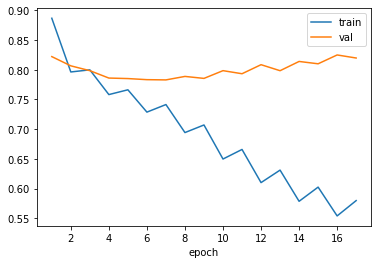

In [27]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

In [28]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [29]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [30]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.8851


In [31]:
with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)